# Load modules

!pip install nltools

In [2]:
import os
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from nltools.stats import regress, zscore
from nltools.data import Brain_Data, Design_Matrix
from nltools.stats import find_spikes 
from nltools.mask import expand_mask

base_dir = '/mnt/c/Users/since/Desktop/KdramaMay/'
data_dir = os.path.join(base_dir, 'data', 'derivatives')
denoised_dir = os.path.join(base_dir, 'denoised', 'denoised_2023')
#Zdenoised_dir = os.path.join(base_dir, 'analysis', 'denoised_zscore')
mask_dir =  os.path.join(base_dir, 'analysis', 'Masks')

/home/sincerely/.conda/envs/fmri01/lib/python3.7/site-packages/nilearn/__init__.py:69: FutureWarning: Python 3.7 support is deprecated and will be removed in release 0.12 of Nilearn. Consider switching to Python 3.9 or 3.10.
  _python_deprecation_warnings()


## Define functions

In [3]:
tr = 1.5
outlier_cutoff = 3 # outlier threashold
#mask = Brain_Data('http://neurovault.org/media/images/2099/Neurosynth%20Parcellation_0.nii.gz')

In [4]:
def make_motion_covariates(mc, tr):
    z_mc = zscore(mc)
    all_mc = pd.concat([z_mc, z_mc**2, z_mc.diff(), z_mc.diff()**2], axis=1)
    all_mc.fillna(value=0, inplace=True) #결측값 변경 
    #print(all_mc)
    return Design_Matrix(all_mc, sampling_freq=1/tr)

# Practice 

## Check Motion Outliers 

In [6]:
sub = '06'
task = 'encoding'
run = '2'
print(glob.glob(os.path.join(data_dir, f'sub-{sub}', 'func', f'sub-{sub}_task-{task}_run-{run}_desc-confounds_timeseries.tsv')))
covariates = pd.read_csv(glob.glob(os.path.join(data_dir, f'sub-{sub}', 'func', f'sub-{sub}_task-{task}_run-{run}_desc-confounds_timeseries.tsv'))[0], sep='\t')

motionOutliers = covariates.filter(regex='motion_outlier')
motionOutliers.columns

['/mnt/c/Users/since/Desktop/KdramaSpring/data/derivatives/sub-06/func/sub-06_task-encoding_run-2_desc-confounds_timeseries.tsv']


Index(['motion_outlier00', 'motion_outlier01', 'motion_outlier02',
       'motion_outlier03'],
      dtype='object')

In [10]:
sub = '02'
task = 'encoding'
run = '1'
print(glob.glob(os.path.join(data_dir, f'sub-{sub}', 'func', f'sub-{sub}_task-{task}_run-{run}_desc-confounds_timeseries.tsv')))
covariates = pd.read_csv(glob.glob(os.path.join(data_dir, f'sub-{sub}', 'func', f'sub-{sub}_task-{task}_run-{run}_desc-confounds_timeseries.tsv'))[0], sep='\t')

nonsteadyOutlier = covariates.filter(regex='non_steady_state_outlier')
nonsteadyOutlier.columns

['/mnt/c/Users/since/Desktop/KdramaSpring/data/derivatives/sub-02/func/sub-02_task-encoding_run-1_desc-confounds_timeseries.tsv']


Index(['non_steady_state_outlier00'], dtype='object')

## sub-02 : Check non_steady_~

In [61]:
file_list = [x for x in glob.glob(os.path.join(data_dir, 'sub-02/func/*AROMA*gz')) if 'denoised' not in x] 
for f in file_list:
    print(type(f))
    sub = os.path.basename(f).split('_')[0]
    task = os.path.basename(f).split('_')[1]
    print(os.path.basename(f).split('_'))

<class 'str'>
['sub-02', 'task-encoding', 'run-1', 'space-MNI152NLin6Asym', 'desc-smoothAROMAnonaggr', 'bold.nii.gz']
<class 'str'>
['sub-02', 'task-encoding', 'run-2', 'space-MNI152NLin6Asym', 'desc-smoothAROMAnonaggr', 'bold.nii.gz']
<class 'str'>
['sub-02', 'task-recall', 'run-1', 'space-MNI152NLin6Asym', 'desc-smoothAROMAnonaggr', 'bold.nii.gz']
<class 'str'>
['sub-02', 'task-recall', 'run-2', 'space-MNI152NLin6Asym', 'desc-smoothAROMAnonaggr', 'bold.nii.gz']


In [22]:
sub = 'sub-02'
task = 'task-encoding'
run = 'run-1'
fwhm = 6
glob.glob(os.path.join(data_dir, sub, 'func', f'{sub}_{task}_{run}_desc-confounds_timeseries.tsv'))

['/mnt/c/Users/since/Desktop/KdramaSpring/data/derivatives/sub-02/func/sub-02_task-encoding_run-1_desc-confounds_timeseries.tsv']

In [14]:
covariates = pd.read_csv(glob.glob(os.path.join(data_dir, sub, 'func', f'{sub}_{task}_{run}_desc-confounds_timeseries.tsv'))[0], sep='\t')
motionOutliers = covariates.filter(regex='motion_outlier')
motionOutliers

,motion_outlier00,motion_outlier01,motion_outlier02,motion_outlier03,motion_outlier04,motion_outlier05,motion_outlier06,motion_outlier07,motion_outlier08,motion_outlier09,...,motion_outlier59,motion_outlier60,motion_outlier61,motion_outlier62,motion_outlier63,motion_outlier64,motion_outlier65,motion_outlier66,motion_outlier67,motion_outlier68
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
599,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
600,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
601,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
602,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [44]:
# '/mnt/c/Users/since/Desktop/KdramaSpring/data/derivatives/sub-02/anat'
csf = Brain_Data(glob.glob(os.path.join(data_dir, f'sub-{sub}', 'anat'))[1]) #MNI CSF 
data = Brain_Data(glob.glob(os.path.join(data_dir, 'sub-02/func/*AROMA*gz'))[3])
dm_csf = zscore(pd.Series(data.extract_roi(csf.threshold(upper=0.85, binarize=True))))


#print(path)
#glob.glob(path)

In [46]:
dm_csf # Luke Chang Code 에서 따온 거 

0      0.073525
1      0.382782
2      0.085099
3      1.381876
4      1.240440
         ...   
487    0.727603
488   -0.514457
489   -0.952690
490   -1.106066
491   -0.504675
Length: 492, dtype: float32

In [47]:
covariates['csf'] # Dart Brain Code에서 따온 거 

0      365.921854
1      361.504711
2      362.139943
3      362.673126
4      359.736969
          ...    
487    357.268896
488    355.207643
489    355.124861
490    353.948480
491    354.677546
Name: csf, Length: 492, dtype: float64

In [67]:
glob.glob(os.path.join(data_dir, f'{sub}', 'anat', '*CSF*.nii.gz'))

['/mnt/c/Users/since/Desktop/KdramaSpring/data/derivatives/sub-02/anat/sub-02_label-CSF_probseg.nii.gz',
 '/mnt/c/Users/since/Desktop/KdramaSpring/data/derivatives/sub-02/anat/sub-02_space-MNI152NLin6Asym_res-2_label-CSF_probseg.nii.gz']

In [62]:
file_list

['/mnt/c/Users/since/Desktop/KdramaSpring/data/derivatives/sub-02/func/sub-02_task-encoding_run-1_space-MNI152NLin6Asym_desc-smoothAROMAnonaggr_bold.nii.gz',
 '/mnt/c/Users/since/Desktop/KdramaSpring/data/derivatives/sub-02/func/sub-02_task-encoding_run-2_space-MNI152NLin6Asym_desc-smoothAROMAnonaggr_bold.nii.gz',
 '/mnt/c/Users/since/Desktop/KdramaSpring/data/derivatives/sub-02/func/sub-02_task-recall_run-1_space-MNI152NLin6Asym_desc-smoothAROMAnonaggr_bold.nii.gz',
 '/mnt/c/Users/since/Desktop/KdramaSpring/data/derivatives/sub-02/func/sub-02_task-recall_run-2_space-MNI152NLin6Asym_desc-smoothAROMAnonaggr_bold.nii.gz']

FileNotFoundError: [Errno 2] No such file or directory: '/mnt/c/Users/since/Desktop/KdramaMay/denoised/denosied_2023/sub-02_denoise_task-encoding_run-1_space-MNI152NLin6Asym_desc-preproc_bold.nii.gz'

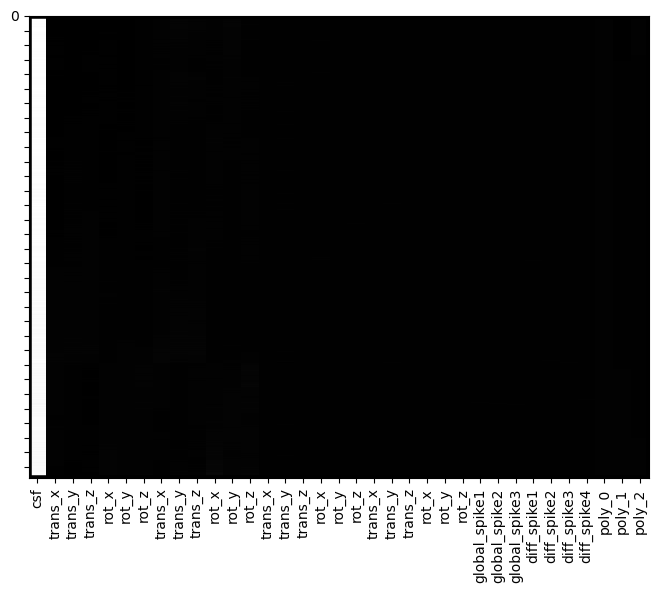

In [14]:
file_list = [x for x in glob.glob(os.path.join(data_dir, 'sub-02/func/*preproc*.nii.gz')) if 'denoised' not in x] 

for f in file_list:
    sub = os.path.basename(f).split('_')[0]
    task = os.path.basename(f).split('_')[1]
    run = os.path.basename(f).split('_')[2]
    
    #csf = Brain_Data(glob.glob(os.path.join(data_dir, f'{sub}', 'anat', '*CSF*.nii.gz'))[1])
    data = Brain_Data(f) #denoise 
    smoothed = data.smooth(fwhm=fwhm)

    spikes = smoothed.find_spikes(global_spike_cutoff=outlier_cutoff, diff_spike_cutoff=outlier_cutoff) # global signal outlier
    covariates = pd.read_csv(glob.glob(os.path.join(data_dir, sub, 'func', f'*{sub}_{task}_{run}_desc-confounds_timeseries.tsv'))[0], sep='\t')
    motionOutliers = covariates.filter(regex='motion_outlier')
    
    mc = covariates[['trans_x','trans_y','trans_z','rot_x', 'rot_y', 'rot_z']]
    mc_cov = make_motion_covariates(mc, tr) #motion parameter
    #csf = zscore(pd.Series(smoothed.extract_roi(csf.threshold(upper=0.85, binarize=True)))) # Mean activity of CSF
    csf = covariates['csf']
    
    # sub-02_task-encoding_run-2에서만 non_steady_outlier가 관측됨.. 그래서 여기서만 빼기로 하였다. 
    if f == '/mnt/c/Users/since/Desktop/KdramaSpring/data/derivatives/sub-02/func/sub-02_task-encoding_run-1_space-MNI152NLin6Asym_desc-smoothAROMAnonaggr_bold.nii.gz':
        dm = Design_Matrix(pd.concat([csf, mc_cov, motionOutliers, nonsteadyOutlier, spikes.drop(labels='TR', axis=1)], axis=1), sampling_freq=1/tr)
        dm = dm.add_poly(order=2, include_lower=True) # Add Intercept, Linear and Quadratic Trends
        dm.heatmap()
    else:
        dm = Design_Matrix(pd.concat([csf, mc_cov, motionOutliers, spikes.drop(labels='TR', axis=1)], axis=1), sampling_freq=1/tr)
        dm = dm.add_poly(order=2, include_lower=True) # Add Intercept, Linear and Quadratic Trends
        dm.heatmap()
    
    smoothed.X = dm
    stats = smoothed.regress()
    stats['residual'].data = np.float32(stats['residual'].data) # cast as float32 to reduce storage space
    stats['residual'].write(os.path.join(denoised_dir, f'{sub}_denoise_{task}_{run}_space-MNI152NLin6Asym_desc-preproc_bold.nii.gz'))
    print( f'finisih_{task}_{run}_data')

In [29]:
print(task)
print(run)
print(denoised_dir)
glob.glob(os.path.join(denoised_dir, f'sub-02_denoise_{task}_{run}_*.nii.gz'))

task-encoding
run-1
/mnt/c/Users/since/Desktop/KdramaMay/denoised/denoised_2023


['/mnt/c/Users/since/Desktop/KdramaMay/denoised/denoised_2023/sub-02_denoise_task-encoding_run-1_space-MNI152NLin6Asym_desc-preproc_bold.nii.gz']

In [38]:
# We also saved the denoised viewing data as an hdf5 file to speed up loading times when using nltools.

file_list = glob.glob(os.path.join(result_dir, f'*AROMA*nii.gz'))
for f in file_list:
    data = Brain_Data(f)
    data.write(f"{f.split('.nii.gz')[0]}.hdf5")

In [39]:
# we have also precomputed average activations within a whole brain parcellation (n=50) 

mask = Brain_Data('http://neurovault.org/media/images/2099/Neurosynth%20Parcellation_0.nii.gz')

file_list = glob.glob(os.path.join(result_dir, '*hdf5'))
for f in file_list:
    sub = os.path.basename(f).split('_')[0]
    task = os.path.basename(f).split('_')[3]
    run = os.path.basename(f).split('_')[4]
    data = Brain_Data(f)
    roi = data.extract_roi(mask)
    pd.DataFrame(roi.T).to_csv(os.path.join(result_dir, f'{sub}_{task}_{run}_Average_ROI_n50.csv'), index=False)
    print(f'finish_{sub}_{task}_{run}') 

/home/sincerely/.conda/envs/fmri01/lib/python3.7/site-packages/nilearn/masking.py:916: UserWarning: Data array used to create a new image contains 64-bit ints. This is likely due to creating the array with numpy and passing `int` as the `dtype`. Many tools such as FSL and SPM cannot deal with int64 in Nifti images, so for compatibility the data has been converted to int32.
  return new_img_like(mask_img, unmasked, affine)


finish_sub-02_task-encoding_run-1
finish_sub-02_task-encoding_run-2
finish_sub-02_task-encoding_run-3
finish_sub-02_task-encoding_run-4
finish_sub-02_task-recall_run-1
finish_sub-02_task-recall_run-2


In [137]:
print(f)
print(run)
print(os.path.basename(f).split('_')[0])
print(f'{sub}_{task}_{run}_Average_ROI_n50.csv')
os.path.basename(f).split('_')

/mnt/c/Users/since/Desktop/Kdrama/data/derivatives/sub-02/func/denoise/sub-02_denoise_AROMA_task-recall_run-2_space-MNI152NLin6Asym_desc-smoothAROMAnonaggr_bold.hdf5
AROMA
sub-02
sub-02_denoise_AROMA_Average_ROI_n50.csv


['sub-02',
 'denoise',
 'AROMA',
 'task-recall',
 'run-2',
 'space-MNI152NLin6Asym',
 'desc-smoothAROMAnonaggr',
 'bold.hdf5']

# Denoising Entire subjects

In [12]:
#subjects = ['10', '11', '12', '13', '14', '15', '16']  # 09 & 11 exclude 
subjects = ['9','29', '30', '31', '32', '33']
fwhm = 6
tr = 1.5
outlier_cutoff = 3

In [30]:
for s in subjects:
    print(s)
    file_list = glob.glob(os.path.join(data_dir, f'sub-{s}', 'func', '*preproc*.nii.gz'))
    print(len(file_list))
    for f in file_list:
        sub = os.path.basename(f).split('_')[0]
        task = os.path.basename(f).split('_')[1]
        run = os.path.basename(f).split('_')[2]
           
        # if not os.path.exists(result_dir):
        #     os.makedirs(result_dir)
        csf = Brain_Data(glob.glob(os.path.join(data_dir, f'{sub}', 'anat', '*CSF*.nii.gz'))[1])
        data = Brain_Data(f) #denoise 
        smoothed = data.smooth(fwhm=fwhm)   # Spatial smoothing 
        
        spikes = smoothed.find_spikes(global_spike_cutoff=outlier_cutoff, diff_spike_cutoff=outlier_cutoff) #FD가 2std 초과하는 것들만 Outlier로 만들었다. 
        covariates = pd.read_csv(glob.glob(os.path.join(data_dir, sub, 'func', f'{sub}_{task}_{run}_desc-confounds_timeseries.tsv'))[0], sep='\t') #Motion params !! 
        
        mc = covariates[['trans_x','trans_y','trans_z','rot_x', 'rot_y', 'rot_z']]
        mc_cov = make_motion_covariates(mc, tr)
        motionOutliers = covariates.filter(regex='motion_outlier')
        
        csf = zscore(pd.Series(smoothed.extract_roi(csf.threshold(upper=0.85, binarize=True)))) # Use CSF from fmriprep output
        
        dm = Design_Matrix(pd.concat([csf, mc_cov, motionOutliers, spikes.drop(labels='TR', axis=1)], axis=1), sampling_freq=1/tr)
        dm = dm.add_poly(order=2, include_lower=True) # Add Intercept, Linear and Quadratic Trends

        smoothed.X = dm 
        stats = smoothed.regress()
        #stats['residual'].data = np.float32(stats['residual'].data) # cast as float32 to reduce storage space
        stats['residual'].write(os.path.join(denoised_dir, f'{sub}_denoise_{task}_{run}_space-MNI152NLin6Asym_desc-preproc_bold.nii.gz'))
        print( f'finisih_{sub}_{task}_{run}_data')

9
0
29
4
finisih_sub-29_task-encoding_run-1_data
finisih_sub-29_task-encoding_run-2_data
finisih_sub-29_task-recall_run-1_data
finisih_sub-29_task-recall_run-2_data
30
4
finisih_sub-30_task-encoding_run-1_data
finisih_sub-30_task-encoding_run-2_data
finisih_sub-30_task-recall_run-1_data
finisih_sub-30_task-recall_run-2_data
31
4
finisih_sub-31_task-encoding_run-1_data
finisih_sub-31_task-encoding_run-2_data
finisih_sub-31_task-recall_run-1_data
finisih_sub-31_task-recall_run-2_data
32
4
finisih_sub-32_task-encoding_run-1_data
finisih_sub-32_task-encoding_run-2_data
finisih_sub-32_task-recall_run-1_data
finisih_sub-32_task-recall_run-2_data
33
4
finisih_sub-33_task-encoding_run-1_data
finisih_sub-33_task-encoding_run-2_data
finisih_sub-33_task-recall_run-1_data
finisih_sub-33_task-recall_run-2_data


# Make hdf5 file

cropped denoised viewing data as an hdf5 file

In [32]:
# We also saved the denoised viewing data as an hdf5 file to speed up loading times when using nltools.
subjects = ['9','29', '30', '31', '32', '33']
for s in subjects:
    file_list = glob.glob(os.path.join(denoised_dir, f'sub-{s}*.nii.gz'))
    #print(file_list)
    for f in file_list:
        data = Brain_Data(f)
        data.write(f"{f.split('.nii.gz')[0]}.hdf5")
        print('finish'+f"{f.split('.nii.gz')[0]}.hdf5")

finish/mnt/c/Users/since/Desktop/KdramaMay/denoised/denoised_2023/sub-29_denoise_task-encoding_run-1_space-MNI152NLin6Asym_desc-preproc_bold.hdf5
finish/mnt/c/Users/since/Desktop/KdramaMay/denoised/denoised_2023/sub-29_denoise_task-encoding_run-2_space-MNI152NLin6Asym_desc-preproc_bold.hdf5
finish/mnt/c/Users/since/Desktop/KdramaMay/denoised/denoised_2023/sub-29_denoise_task-recall_run-1_space-MNI152NLin6Asym_desc-preproc_bold.hdf5
finish/mnt/c/Users/since/Desktop/KdramaMay/denoised/denoised_2023/sub-29_denoise_task-recall_run-2_space-MNI152NLin6Asym_desc-preproc_bold.hdf5
finish/mnt/c/Users/since/Desktop/KdramaMay/denoised/denoised_2023/sub-30_denoise_task-encoding_run-1_space-MNI152NLin6Asym_desc-preproc_bold.hdf5
finish/mnt/c/Users/since/Desktop/KdramaMay/denoised/denoised_2023/sub-30_denoise_task-encoding_run-2_space-MNI152NLin6Asym_desc-preproc_bold.hdf5
finish/mnt/c/Users/since/Desktop/KdramaMay/denoised/denoised_2023/sub-30_denoise_task-recall_run-1_space-MNI152NLin6Asym_desc-pr

# Get each ROIs

In [3]:
mask_path = os.path.join(base_dir,'analysis', 'Masks', 'Neurosynth_Parcellation_0.nii.gz') #3iso 짜리, Dartbrain에서 사용한 ROI인데 cortex 쪽에만 존재한다. 
mask = Brain_Data(mask_path)
mask_x = expand_mask(mask)
subjects = ['17', '18', '19', '20', '21','22', '23','24','25', '26', '27', '28'] 
for s in subjects:
    file_list = glob.glob(os.path.join(denoised_dir, f'sub-{s}_*.hdf5'))
    for f in file_list:
        sub = os.path.basename(f).split('_')[0]
        task = os.path.basename(f).split('_')[2]
        run = os.path.basename(f).split('_')[3]    
        data = Brain_Data(f)
        for i,m in enumerate(mask_x):
            roi = data.apply_mask(m)
            pd.DataFrame(roi.data).to_csv(os.path.join(denoised_dir, 'ROIs', f'{sub}_{task}_{run}_denoised_roi{i}.csv' ), index=False)

/home/sincerely/.conda/envs/fmri01/lib/python3.7/site-packages/nilearn/masking.py:858: UserWarning: Data array used to create a new image contains 64-bit ints. This is likely due to creating the array with numpy and passing `int` as the `dtype`. Many tools such as FSL and SPM cannot deal with int64 in Nifti images, so for compatibility the data has been converted to int32.
  return new_img_like(mask_img, unmasked, affine)


## Check ROI size whether it is 3 iso

In [10]:
import os 
import nibabel as nib
import numpy as np

# Load the NIfTI file
file_path = os.path.join(base_dir, 'analysis', 'Masks', "Neurosynth_Parcellation_0.nii.gz")
img = nib.load(file_path)

# Get the image data and header
data = img.get_fdata()
header = img.header

# Update the voxel dimensions
current_voxel_dims = header["pixdim"][1:4]  # Get the current voxel dimensions

# Get Averaged ROIs

In [34]:
# we have also precomputed average activations within a whole brain parcellation (n=50) 
mask = Brain_Data('http://neurovault.org/media/images/2099/Neurosynth%20Parcellation_0.nii.gz')
#mask = Brain_Data(os.path.join(base_dir,'analysis', 'Masks', 'k50_2mm.nii.gz'))
#mask_x = expand_mask(mask)
#subjects = ['sub-01', 'sub-02', 'sub-03', 'sub-05']
#for s in subjects:
    #result_dir = os.path.join(data_dir, f'sub-{s}', 'func', 'denoise')
for s in subjects:
    print(s)
    #file_list = glob.glob(os.path.join(data_dir, f'sub-{s}', 'func', '*preproc*.nii.gz'))    
    file_list = glob.glob(os.path.join(denoised_dir, f'sub-{s}_*hdf5'))
    print(file_list)
    for f in file_list:
        sub = os.path.basename(f).split('_')[0]
        task = os.path.basename(f).split('_')[2]
        run = os.path.basename(f).split('_')[3]
        data = Brain_Data(f)
        roi = data.extract_roi(mask)
        pd.DataFrame(roi.T).to_csv(os.path.join(denoised_dir, 'Averaged_ROI', f'{sub}_{task}_{run}_Average_ROI_n50.csv'), index=False)
        print(f'finish_{sub}_{task}_{run}') 

9
[]
29
['/mnt/c/Users/since/Desktop/KdramaMay/denoised/denoised_2023/sub-29_denoise_task-encoding_run-1_space-MNI152NLin6Asym_desc-preproc_bold.hdf5', '/mnt/c/Users/since/Desktop/KdramaMay/denoised/denoised_2023/sub-29_denoise_task-encoding_run-2_space-MNI152NLin6Asym_desc-preproc_bold.hdf5', '/mnt/c/Users/since/Desktop/KdramaMay/denoised/denoised_2023/sub-29_denoise_task-recall_run-1_space-MNI152NLin6Asym_desc-preproc_bold.hdf5', '/mnt/c/Users/since/Desktop/KdramaMay/denoised/denoised_2023/sub-29_denoise_task-recall_run-2_space-MNI152NLin6Asym_desc-preproc_bold.hdf5']
finish_sub-29_task-encoding_run-1
finish_sub-29_task-encoding_run-2
finish_sub-29_task-recall_run-1
finish_sub-29_task-recall_run-2
30
['/mnt/c/Users/since/Desktop/KdramaMay/denoised/denoised_2023/sub-30_denoise_task-encoding_run-1_space-MNI152NLin6Asym_desc-preproc_bold.hdf5', '/mnt/c/Users/since/Desktop/KdramaMay/denoised/denoised_2023/sub-30_denoise_task-encoding_run-2_space-MNI152NLin6Asym_desc-preproc_bold.hdf5', '